In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from flowFieldWavy import *
from flowFieldArray import *
from pseudo import *
from laminar import *
import time

flowDict = getDefaultDict()
flowDict.update({'eps':0.02,'alpha':20.,'beta':0.,'L':5,'M':0,'N':50,'nd':4, 'isPois':1})





In [ ]:
vf1, pf1, fnormArr, flg = iterate(flowDict=flowDict)

In [ ]:
vff = vf1.slice(L=vf1.nx//2+2); pff = pf1.slice(L=vf1.nx//2+2)
#vff = vf1.copy(); pff=pf1.copy()
vff.residuals(pField=pff).slice(L=vf1.nx//2).norm()

In [ ]:
vf = vf1.copy(); pf = pf1.copy()
vff = vf.slice(L=vf.nx//2+2); pff = pf.slice(L=vf.nx//2+2)
#vff.residuals(pField=pff).slice(L=vf1.nx//2).norm()
res = vff.convNL() + pff.grad() - vff.laplacian()/vff.flowDict['Re']
res = res.slice(L=vf.nx//2)
res.view4d()[0,res.nx//2,0,0] += -2./res.flowDict['Re']
res.norm(), vff.residuals(pField=pff).slice(L=vf.nx//2).norm()

In [ ]:
res[0,:,0,:,[0,-1]]=0.
res.norm(), res.getScalar().norm(), res.getScalar(nd=1).norm()

In [ ]:
uRes = res.getScalar(); vRes = res.getScalar(nd=1)
#uRes[0,:,0,0,[0,-1]]=0.
uRes.norm(), vRes.norm()

In [ ]:
res = (vf1.convNL()+pf1.grad()-vf1.laplacian()/vf1.flowDict['Re'])
res[0,res.nx//2,0,0] += -2./vf1.flowDict['Re']
res.norm()

In [ ]:
vf2,pf2,fnormArr,flg = iterate(flowDict=vf1.flowDict,rect=True)

In [145]:
vf, pf, fnorm, flg = runMATLAB(N=flowDict['N'], n=flowDict['L'], Re=flowDict['Re'], eps=flowDict['eps'],g=flowDict['alpha']*flowDict['eps'])

In [146]:
saveff(vf,pf)

In [151]:
#vf0 = vf.copy(); pf0 = pf.copy()
fName = dict2name(vf0.flowDict)+'.npy'
vf,pf = loadff(fName)

In [153]:
(vf-vf0).norm(), vf.norm(), (pf-pf0).norm(),  vf.residuals(pField=pf).norm()

(0.0, 1.226247584280389, 0.0, 4.1253052773839274e-05)

In [94]:
vf = dict2ff(flowDict); pf=vf.getScalar().zero()

In [95]:
J0, F0, fnorm0 = makeSystem(vf=vf,pf=pf,resNorm=True,rect=False)
J1,F1,fnorm1 = makeSystem(vf=vf,pf=pf, resNorm=True,rect=True)
norm=np.linalg.norm

In [48]:
fnorm0-fnorm1

-1.3018962203847906e-06

In [136]:
N = flowDict['N']; N4 = 4*N; m = vf.nx
#BCrows = N4*np.arange(m).reshape((m,1)) + np.array([0,N-1,N,2*N-1,2*N,3*N-1]).reshape((1,6))
#BCrows = N4*(m//2)+ np.array([0,N-1,N,2*N-1,2*N,3*N-1]).reshape((1,6))
BCrows = N4*np.array([0,m-1]).reshape((2,1)) + np.array([0,N-1,N,2*N-1]).reshape((1,4))
BCrows = BCrows.flatten()
#BCrows = np.append(BCrows,np.array([F1.size-1]))

In [137]:
F10 = np.delete(F1,BCrows)
#F0.shape, F10.shape, norm(F0-F10)

In [138]:
J10 = np.delete(J1,BCrows,axis=0)
#J0.shape,J10.shape, norm((J0-J10).flatten())

In [139]:
dx0,linRes0,r0,s0 = np.linalg.lstsq(J0,-F0,rcond=1.0e-9)
dx1,linRes1,r1,s1 = np.linalg.lstsq(J1,-F1,rcond=1.0e-9)
dx10,linRes10,r10,s10 = np.linalg.lstsq(J10,-F10,rcond=1.0e-9)

In [140]:
print(linRes0,linRes1,linRes10, r0,r1,r10 )
s0[-3:],s1[-3:],s10[-3:], norm(dx0),norm(dx1), norm(dx10), norm(dx0-dx1), norm(dx0-dx10)

[] [] [] 2198 2199 2199


(array([  5.57519857e-03,   7.62269956e-12,   7.18997732e-14]),
 array([  5.93364948e-03,   5.57519869e-03,   1.48674378e-11]),
 array([  5.93364948e-03,   5.57519867e-03,   1.47632948e-11]),
 0.39446700298489357,
 0.39446699435988802,
 0.39446699403524144,
 2.1012523901949997e-07,
 2.080603832956102e-07)

In [141]:
norm((np.dot(J0,dx0)+F0)), norm((np.dot(J1,dx1)+F1)), norm((np.dot(J10,dx10)+F10))

(7.8966613033780981e-14, 3.3401243795407183e-06, 3.0435489508285927e-06)

In [73]:
linResArr1 = (np.dot(J1,dx1)+F1)

In [79]:
nonZero = np.arange(F1.size)[np.abs(linResArr1)>5.0e-14]

In [91]:
dx0t = dx0.reshape(vf.nx,4,vf.N)
#dx0t[vf.nx//2,3] = 0.
dx10t = dx10.reshape(vf.nx,4,vf.N)
#dx10t[vf.nx//2,3] = 0.
#norm(dx0t.flatten()-dx10t.flatten())
norm(dx0t[vf.nx//2,3]-dx10t[vf.nx//2,3])

0.0

In [166]:
flowDict = getDefaultDict()
flowDict.update({'eps':0.05,'alpha':20.,'beta':0.,'Re':100.,'L':8,'M':0,'N':50,'nd':4, 'isPois':1})

In [ ]:
gArr = 0.5*np.arange(0.125,3.125,0.125)
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
start = time.time()
for g in gArr:
    start1 = time.time()
    a = g/flowDict['eps']
    vf.flowDict = updateDict(vf.flowDict,{'alpha':a})
    pf.flowDict = updateDict(pf.flowDict,{'alpha':a})
    vf,pf,fnormArr,flg = iterate(vf=vf, pf=pf,rect=False)
    saveff(vf,pf)
    print('g:',g, ' runtime:', time.time()-start1, ',  total time elapsed:',time.time()-start)
    print('**********************************************************')

In [167]:
tempDict = updateDict(flowDict.copy(),{'Re':100.})
start = time.time()
for g in gArr[-3:]:
    start1 = time.time()
    a = g/flowDict['eps']
    tempDict.update({'alpha':a})
    vf,pf = loadff(dict2name(tempDict))
    vf.flowDict.update({'Re':10.}); pf.flowDict.update({'Re':10.})
    vf,pf,fnormArr,flg = iterate(vf=vf, pf=pf,rect=False,tol=1.0e-13)
    saveff(vf,pf)
    print('runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))

Starting iterations...............
Iterations have converged, Returning....................................
g: 1.375  runtime: 222 ,  total time elapsed: 222
Starting iterations...............
Iterations have converged, Returning....................................
g: 1.4375  runtime: 190 ,  total time elapsed: 412
Starting iterations...............
Iterations have converged, Returning....................................
g: 1.5  runtime: 121 ,  total time elapsed: 533


In [164]:
gArr

array([ 0.0625,  0.125 ,  0.1875,  0.25  ,  0.3125,  0.375 ,  0.4375,
        0.5   ,  0.5625,  0.625 ,  0.6875,  0.75  ,  0.8125,  0.875 ,
        0.9375,  1.    ,  1.0625,  1.125 ,  1.1875,  1.25  ,  1.3125,
        1.375 ,  1.4375,  1.5   ])

In [ ]:
flowDict = getDefaultDict()
Re = 10.
flowDict.update({'eps':0.05,'alpha':20.,'beta':0.,'Re':Re,'L':8,'M':0,'N':50,'nd':4, 'isPois':1})

epsArr = np.arange(0.025,0.0,-0.005)
gArr = np.arange(0.05,1.55,0.05)


flowDict.update({'eps':float(epsArr[0]),'alpha':float(gArr[0]/epsArr[0])})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
start = time.time()
for k in range(epsArr.size):
    eps = epsArr[k]
    flowDict.update({'eps':float(eps)})
    if k!=0:
        vf = vfG0;  pf = pfG0
    for g in gArr:
        a = float(g)/flowDict['eps']
        flowDict.update({'alpha':a})
        
        vf.flowDict=updateDict(flowDict,{'nd':3}); pf.flowDict = updateDict(flowDict,{'nd':1})
        start1 = time.time()
        print('eps:',eps,', g:',g, ', Re:',Re)
        if g > gArr[0]:
            vf[:] = vf[:] + dvf[:]; pf[:] = pf[:] + dpf[:]
        else:
            vfG0 = vf.copy(); pfG0 = pf.copy()
        
        vf0 = vf.copy(); pf0 = pf.copy()
        vf,pf,fnormArr,flg = iterate(vf=vf0, pf=pf0,rect=False,tol=1.0e-13)
        dvf = vf - vf0; dpf = pf - pf0
        
        saveff(vf,pf)
        print('Runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))
        print('**************************************')

In [ ]:
flowDict = getDefaultDict()
Re = 100.
flowDict.update({'eps':0.05,'alpha':20.,'beta':0.,'Re':Re,'L':8,'M':0,'N':50,'nd':4, 'isPois':1})

epsArr = np.arange(0.005,0.102,0.005)
gArr = np.arange(0.05,1.55,0.05)

flowDict.update({'eps':np.float(epsArr[0]),'alpha':np.float(gArr[0]/epsArr[0])})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
start = time.time()
for k in range(epsArr.size):
    eps = epsArr[k]
    flowDict.update({'eps':np.float(eps)})
    if k!=0:
        vf = vfG0;  pf = pfG0
    for g in gArr:
        a = g/flowDict['eps']
        flowDict.update({'alpha':np.float(a)})
        
        vf.flowDict=updateDict(flowDict,{'nd':3}); pf.flowDict = updateDict(flowDict,{'nd':1})
        start1 = time.time()
        print('eps:',eps,', g:',g, ', Re:',Re)
        if g > gArr[0]:
            vf[:] = vf[:] + dvf[:]; pf[:] = pf[:] + dpf[:]
        else:
            vfG0 = vf.copy(); pfG0 = pf.copy()
        
        vf0 = vf.copy(); pf0 = pf.copy()
        vf,pf,fnormArr,flg = iterate(vf=vf0, pf=pf0,rect=False,tol=1.0e-13)
        dvf = vf - vf0; dpf = pf - pf0
        
        saveff(vf,pf)
        print('Runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))
        print('**************************************')

In [ ]:
flowDict = getDefaultDict()
Re = 100.
flowDict.update({'eps':0.05,'alpha':20.,'beta':0.,'Re':Re,'L':8,'M':0,'N':50,'nd':4, 'isPois':1})

epsArr = np.arange(0.005,0.102,0.005)
gArr = np.arange(0.05,1.55,0.05)

flowDict.update({'eps':np.float(epsArr[0]),'alpha':np.float(gArr[0]/epsArr[0])})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
start = time.time()
for k in range(epsArr.size):
    eps = epsArr[k]
    flowDict.update({'eps':np.float(eps)})
    for g in gArr:
        a = g/flowDict['eps']
        flowDict.update({'alpha':np.float(a)})
        
        vf,pf = loadff(dict2name(updateDict(flowDict,{'Re':10.})))
        vf.flowDict.update({'Re':Re}); pf.flowDict.update({'Re':Re})
        start1 = time.time()
        print('eps:',eps,', g:',g, ', Re:',Re)
        
        vf,pf,fnormArr,flg = iterate(vf=vf, pf=pf,rect=False,tol=1.0e-13)
        
        saveff(vf,pf)
        print('Runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))
        print('**************************************')

In [ ]:
flowDict = getDefaultDict()
Re = 10.
flowDict.update({'eps':0.005,'alpha':20.,'beta':0.,'Re':Re,'L':8,'M':0,'N':50,'nd':4, 'isPois':1})
g = 0.1; flowDict.update({'alpha':float(0.005/g)})
vf,pf = loadff(dict2name(flowDict))

In [5]:
epsArr = np.arange(0.075,0.05,-0.005)

start = time.time()
for k in range(2):
    eps = epsArr[k]
    flowDict.update({'eps':eps})
    print('%04d' %(int(eps*1.0e04)), flowDict['eps'], type(flowDict['eps']))

0750 0.075 <class 'numpy.float64'>
0699 0.07 <class 'numpy.float64'>


In [17]:
import os 
files= [f for f in os.listdir('./solutions/Re100/')]
files.sort()


In [ ]:
loadPath = 'solutions/Re100/'
savePath = 'solutions/Re1000/'
start = time.time()
for f in files[-180:]:
    start1 = time.time()
    vf,pf = loadff(loadPath+f)
    vf.flowDict.update({'Re':1000.}); pf.flowDict.update({'Re':1000.})
    print('2*eps:',2.*vf.flowDict['eps'], ' 2*g:', 2.*vf.flowDict['eps']*vf.flowDict['alpha'])
    vf,pf,fnormArr,flg = iterate(vf=vf, pf=pf,rect=False,tol=1.0e-13)
    saveff(vf,pf,prefix=savePath)
    print('Runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))
    print('**************************************')

    
    
    

In [ ]:
neps = 15; ng = 30; nRe = 1
vArr = flowFieldArray(vList,neps,ng,nRe); pArr = flowFieldArray(pList,neps,ng,nRe)


In [16]:
pDrag = np.zeros(pArr.shape)
for k1 in range(neps):
    for k2 in range(ng):
        pf = pArr[k1,k2,0].field
        pDrag[k1,k2,0] = presDrag(pf)[0]
        

In [23]:
pDrag[:,29,0]/(4./10.)

array([ 0.79459179,  0.71628525,  0.6914274 ,  0.68003361,  0.68140409,
        0.67450013,  0.67648491,  0.68392692,  0.68870329,  0.69100133,
        0.69282391,  0.69479164,  0.69685027,  0.69892142,  0.70098906])

In [29]:
epsArr = pArr.getProperty('eps'); gArr = pArr.getProperty('g')
epsVec = epsArr[:,0,0]; gVec = gArr[0,:,0]

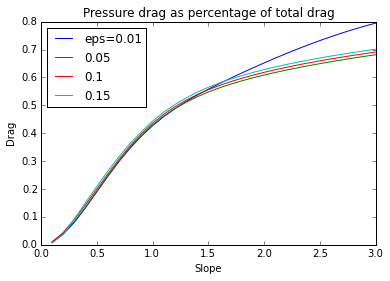

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(2.*gVec, 2.5* pDrag[[0,4,9,14],:,0].T)
plt.title('Pressure drag as percentage of total drag')
plt.xlabel('Slope');plt.ylabel('Drag')
#plt.legend('g=0.1',gVec[5], gVec[10])
plt.savefig('presDragG.pdf',format='pdf')
plt.legend(['eps=0.01','0.05','0.1','0.15'],loc=2)
plt.show(); 



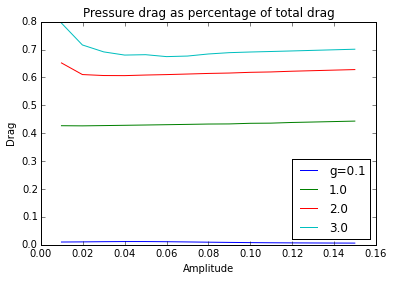

In [45]:
plt.plot(2.*epsVec, 2.5* pDrag[:,[0,9,19,29],0])
plt.title('Pressure drag as percentage of total drag')
plt.xlabel('Amplitude');plt.ylabel('Drag')
#plt.legend('g=0.1',gVec[5], gVec[10])
plt.savefig('presDragE.pdf',format='pdf')
plt.legend(['g=0.1','1.0','2.0','3.0'],loc=4)
plt.show(); 

In [7]:
eps = np.float(0.05)
type(eps) is np.float64

False